<a href="https://colab.research.google.com/github/bickkysahani/timeseries-forecasting/blob/main/timeseries_forecasting_6_weather_prediction_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Weather_data.csv', parse_dates =['datetime (UTC)'])


In [ ]:
df.head()

,datetime (UTC),"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
0,2010-01-01 00:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.26,16.39,2.60,101046.38,0.89,287.01,408.35,1.0
1,2010-01-01 01:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.67,16.29,2.91,101037.96,0.86,360.79,411.02,1.0
2,2010-01-01 02:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.16,15.89,3.26,101017.26,0.87,291.54,410.67,1.0
3,2010-01-01 03:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.46,15.33,3.17,101022.56,0.82,357.11,410.95,1.0
4,2010-01-01 04:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.53,15.11,2.95,100940.03,0.80,459.91,410.00,0.9


In [ ]:
#Lets rename some columns
df = df.rename(columns={'datetime (UTC)':'Date Time',
                                 'coordinates (lat,lon)':'coordinates',
                                  'model (name)':'model',
                                  'model elevation (surface)':'model elevation'
                                  ,'utc_offset (hrs)':'utc',
                                   'temperature (degC)':'Temperature',
                                   'dewpoint_temperature (degC)':'Temperature(dw)',
                                   'wind_speed (m/s)':'Wind Speed',
                                   'mean_sea_level_pressure (Pa)':'Pressure',
                                   'relative_humidity ((0-1))':'Relative Humidity',
                                  'surface_solar_radiation (W/m^2)':'Solar Radiation',
                                  'surface_thermal_radiation (W/m^2)':'Thermal Radiation',
                                  'total_cloud_cover (0-1)':'Total Cloud Cover'
                                  })
#drop some unnecessary columns
df.drop(columns=['coordinates','model','model elevation','utc'], axis=1, inplace=True)

df['Pressure'] = df['Pressure'].apply(lambda x: x*0.01)

In [ ]:
df.head()

,Date Time,Temperature,Temperature(dw),Wind Speed,Pressure,Relative Humidity,Solar Radiation,Thermal Radiation,Total Cloud Cover
0,2010-01-01 00:00:00,18.26,16.39,2.60,1010.4638,0.89,287.01,408.35,1.0
1,2010-01-01 01:00:00,18.67,16.29,2.91,1010.3796,0.86,360.79,411.02,1.0
2,2010-01-01 02:00:00,18.16,15.89,3.26,1010.1726,0.87,291.54,410.67,1.0
3,2010-01-01 03:00:00,18.46,15.33,3.17,1010.2256,0.82,357.11,410.95,1.0
4,2010-01-01 04:00:00,18.53,15.11,2.95,1009.4003,0.80,459.91,410.00,0.9


In [ ]:
features_considered = ['Temperature','Temperature(dw)', 'Wind Speed', 'Pressure','Relative Humidity','Solar Radiation','Thermal Radiation','Total Cloud Cover']
features = df[features_considered]
features.index = df['Date Time']
features.head()
features = features[['Temperature(dw)', 'Wind Speed', 'Pressure','Relative Humidity','Solar Radiation','Thermal Radiation','Total Cloud Cover','Temperature']]

In [ ]:
features.head()

,Temperature(dw),Wind Speed,Pressure,Relative Humidity,Solar Radiation,Thermal Radiation,Total Cloud Cover,Temperature
Date Time,,,,,,,,
2010-01-01 00:00:00,16.39,2.60,1010.4638,0.89,287.01,408.35,1.0,18.26
2010-01-01 01:00:00,16.29,2.91,1010.3796,0.86,360.79,411.02,1.0,18.67
2010-01-01 02:00:00,15.89,3.26,1010.1726,0.87,291.54,410.67,1.0,18.16
2010-01-01 03:00:00,15.33,3.17,1010.2256,0.82,357.11,410.95,1.0,18.46
2010-01-01 04:00:00,15.11,2.95,1009.4003,0.80,459.91,410.00,0.9,18.53


In [ ]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 1

# past = 72
# future = 24
# learning_rate = 0.001
# batch_size = 256
# epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


In [ ]:
features.head()
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
# features.head()
# features.shape
train_data = features.loc[0 : train_split - 1]
test_data = features.loc[train_split:]

In [ ]:
features.head()

,0,1,2,3,4,5,6,7
0,1.868083,-0.628144,-0.572659,1.010458,0.383764,2.522450,1.171198,0.602596
1,1.840567,-0.476359,-0.581543,0.820541,0.659915,2.603226,1.171198,0.675556
2,1.730503,-0.304989,-0.603384,0.883847,0.400719,2.592638,1.171198,0.584800
3,1.576414,-0.349055,-0.597792,0.567319,0.646142,2.601109,1.171198,0.638186
4,1.515879,-0.456774,-0.684870,0.440708,1.030913,2.572368,0.891122,0.650643


In [ ]:
train_data.shape, test_data.shape

((71540, 8), (28517, 8))

In [ ]:
train_data.head()

,0,1,2,3,4,5,6,7
0,1.868083,-0.628144,-0.572659,1.010458,0.383764,2.522450,1.171198,0.602596
1,1.840567,-0.476359,-0.581543,0.820541,0.659915,2.603226,1.171198,0.675556
2,1.730503,-0.304989,-0.603384,0.883847,0.400719,2.592638,1.171198,0.584800
3,1.576414,-0.349055,-0.597792,0.567319,0.646142,2.601109,1.171198,0.638186
4,1.515879,-0.456774,-0.684870,0.440708,1.030913,2.572368,0.891122,0.650643


In [ ]:
# start = past + future
# end = start + train_split

# #splitting features and target label
# x_train = train_data[[i for i in range(7)]].values
# y_train = features.iloc[start:end][[1]]

# sequence_length = int(past / step)
# x_train.shape, y_train.shape


((71540, 7), (71540, 1))

In [ ]:
type(x_train)
x_train[:], y_train[:]

(array([[ 1.86808295, -0.62814379, -0.57265943, ...,  0.38376354,
          2.52244951,  1.171198  ],
        [ 1.84056705, -0.47635885, -0.58154341, ...,  0.65991545,
          2.60322629,  1.171198  ],
        [ 1.73050348, -0.30498875, -0.60338406, ...,  0.40071892,
          2.59263757,  1.171198  ],
        ...,
        [ 1.30675869,  0.77709103, -0.21387131, ..., -0.69048913,
          1.15862287,  1.171198  ],
        [ 1.32877141,  1.0023203 , -0.16429197, ..., -0.69048913,
          1.76581011,  1.171198  ],
        [ 1.28474598,  0.89460195, -0.15208441, ..., -0.69048913,
          1.84023365,  1.171198  ]]),               1
 96     0.018166
 97     0.390284
 98     0.473521
 99     0.434351
 100    0.360906
 ...         ...
 71631 -0.138515
 71632 -0.329470
 71633 -0.525322
 71634 -0.730966
 71635 -0.794618
 
 [71540 rows x 1 columns])

In [ ]:
x_end = len(test_data) - past - future

label_start = train_split + past + future

x_val = test_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]
x_val.shape, y_val.shape

((28421, 7), (28421, 1))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100,max_features=3,random_state=1)

In [ ]:
model.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(max_features=3, random_state=1)

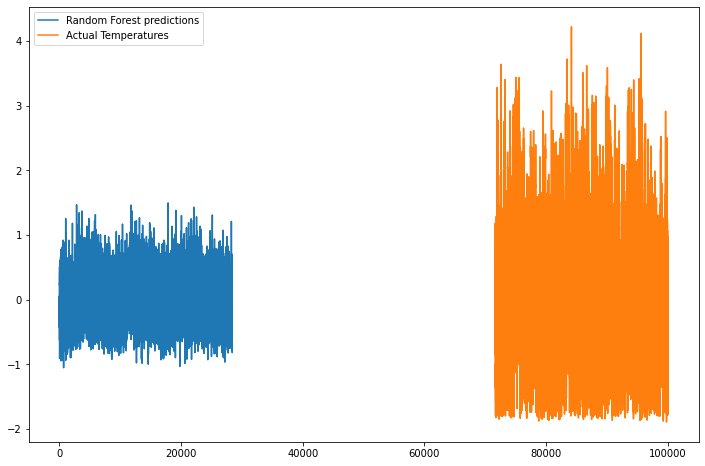

In [ ]:
pred = model.predict(x_val)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(pred,label="Random Forest predictions")
plt.plot(y_val,label="Actual Temperatures")
plt.legend(loc="upper left")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred,y_val))


In [ ]:
print("Mean Squared Error for Random Forest Model is:",rmse)

Mean Squared Error for Random Forest Model is: 1.0262337412484897


In [ ]:
#worked 2 hours